# E-04.  lyrics_generator

## 1. 데이터 읽어오기

In [16]:
import glob
import os, re
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

In [17]:

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)
print(f'The number of lyrics : {len(txt_list)}')


raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("The number of raw corpus:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

The number of lyrics : 49
The number of raw corpus: 187088
Examples:
 ['[Hook]', "I've been down so long, it look like up to me", 'They look up to me']


---

## 2. 데이터 정제
- `preprocess_sentence()`함수 만들기
-  토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외할 것
(다른 데이터들이 과도한 Padding을 갖게 하므로)

**정규 표현식을 이용해서 필터링**
1. 소문자로 바꾸고, 양쪽 공백을 지우기
2. 특수문자 양쪽에 공백을 넣기
3. 여러개의 공백은 하나의 공백으로 바꾸기
4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸기
5. `[]` 해당하는 부분은 파트 분배 임으로 필터링
6. `()` 해당하는 부분은 코러스 부분, 연속된 부분을 표기한 것이므로 필터링
7. 양쪽 공백 지우기
8. 문장 시작에는 `<start>`, 끝에는 `<end>`를 추가
    

In [18]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = re.sub(r"(\[.*\])", '', sentence) # 5
    sentence = re.sub(r"(\(.*\))", '', sentence) # 6
    sentence = sentence.strip() # 7
    sentence = '<start> ' + sentence + ' <end>' # 8
    return sentence


In [19]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == "]": continue    
    if sentence[-1] == ")": continue     
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]


['<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> straight up to my face , straight up to my face <end>',
 '<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> somethin ain t right when we talkin <end>',
 '<start> somethin ain t right when we talkin <end>',
 '<start> look like you hidin your problems <end>']

----

## 3. 평가 데이터셋 분리
- `tokenize()` 함수로 데이터를 `Tensor`로 변환
-  `sklearn` 모듈의 `train_test_split()` 함수를 사용해 훈련 데이터와 평가 데이터를 분리
- 단어장의 크기는 12,000 이상 으로 설정
- 총 데이터의 20% 를 평가 데이터셋으로 사용

In [20]:
def tokenize(corpus):
    # 15000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=15000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    # 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2    5   90 ...   10   12    3]
 [   2   42  131 ...    0    0    0]
 [   2    5   39 ...    0    0    0]
 ...
 [   2   86  716 ...    0    0    0]
 [   2  214    3 ...    0    0    0]
 [   2    9 1300 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f2851a89150>


In [21]:
# 단어사전이 어떻게 구축되었는지 확인한다.
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


- 텐서를 소스와 타겟으로 분리

In [22]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2   5  90 101  59  29 158   4  11 131  24  31  10  12]
[  5  90 101  59  29 158   4  11 131  24  31  10  12   3]


 - train, validation 데이터 분리

In [23]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                       tgt_input,
                                       test_size=0.2,
                                       random_state=7)



print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (133342, 14)
Target Train: (133342, 14)


In [24]:
enc_train2, enc_val2, dec_train2, dec_val2 = train_test_split(enc_train,
                                       dec_train,
                                       test_size=0.15,
                                       random_state=7)



print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (133342, 14)
Target Train: (133342, 14)


 - 데이터셋 객체 생성
     
     - 텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성
     - tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성

In [25]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 512
steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 7000개와, 
#여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다 
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((512, 14), (512, 14)), types: (tf.int32, tf.int32)>

----
## 4. 인공지능 만들기

모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계

In [26]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, dropout = 0.5, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 512
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [27]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(512, 14, 15001), dtype=float32, numpy=
array([[[ 2.82894238e-04, -6.45709661e-05, -1.36316768e-04, ...,
          3.06724032e-05, -3.07589245e-04,  4.28568674e-05],
        [ 2.49079254e-04,  1.44311081e-04, -3.64360516e-04, ...,
          3.15817626e-04, -7.21276854e-04, -1.90669976e-04],
        [-2.52893260e-05,  3.12461489e-04, -6.46914530e-04, ...,
          3.71406757e-04, -5.08299388e-04, -1.43291414e-04],
        ...,
        [-1.69529300e-03,  1.36812089e-03, -1.21944395e-04, ...,
          1.17128843e-03,  1.86690793e-03, -1.30189816e-03],
        [-1.89099228e-03,  1.59666745e-03, -1.04779581e-04, ...,
          1.25293003e-03,  2.24550394e-03, -1.46287668e-03],
        [-2.07564933e-03,  1.78572990e-03, -8.34557650e-05, ...,
          1.30734709e-03,  2.58155935e-03, -1.58402522e-03]],

       [[ 2.82894238e-04, -6.45709661e-05, -1.36316768e-04, ...,
          3.06724032e-05, -3.07589245e-04,  4.28568674e-05],
        [ 2.67819152e-04, -1.97274450e-04,  2

In [28]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  7680512   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  20979712  
_________________________________________________________________
lstm_3 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense_1 (Dense)              multiple                  30737049  
Total params: 92,959,897
Trainable params: 92,959,897
Non-trainable params: 0
_________________________________________________________________


---
### n차 시도
- 하이퍼 파라미터를 여러 조합으로 바꿔서 모델을 학습시켜봤으나, val_loss 값이 2.2 이하로 떨어지질 않았다.
- 고민하던 중 dropout을 추가해보았다.
- 아래 결과는 Rnn1과 Rnn2 LSTM 에 dropout을 각각 0.5로 준 결과이다.

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
data1 = model.fit(enc_train, dec_train, validation_data=(enc_val, dec_val), epochs=10, batch_size=128, verbose=1)

Epoch 1/10
1042/1042 [==============================] - 573s 547ms/step - loss: 3.9679 - val_loss: 3.1224
Epoch 2/10
1042/1042 [==============================] - 574s 551ms/step - loss: 3.0081 - val_loss: 2.8700
Epoch 3/10
1042/1042 [==============================] - 573s 550ms/step - loss: 2.6625 - val_loss: 2.6989
Epoch 4/10
1042/1042 [==============================] - 572s 549ms/step - loss: 2.3433 - val_loss: 2.5842
Epoch 5/10
1042/1042 [==============================] - 570s 547ms/step - loss: 2.0717 - val_loss: 2.5076
Epoch 6/10
1042/1042 [==============================] - 568s 545ms/step - loss: 1.8443 - val_loss: 2.4635
Epoch 7/10
1042/1042 [==============================] - 572s 549ms/step - loss: 1.6586 - val_loss: 2.4421
Epoch 8/10
1042/1042 [==============================] - 568s 545ms/step - loss: 1.5125 - val_loss: 2.4425
Epoch 9/10
1042/1042 [==============================] - 570s 547ms/step - loss: 1.3952 - val_loss: 2.4524
Epoch 10/10
1042/1042 [=======================

- dropout을 Rnn1, Rnn2 LSTM에 모두 0.5씩 설정하였으나, Val_loss값이 유의미하게 떨어지지 않아 다시 설정해보았다.
- 아래 학습에서는 dropout을 Rnn1 LSTM에만 0.5 주었다.

In [29]:
# dropout을 Rnn1에만 0.5로 준 것
# optimizer와 loss등은 나중에 배운다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none')

model.compile(loss=loss, optimizer=optimizer)
data2 = model.fit(enc_train, dec_train, validation_data=(enc_val2, dec_val2), epochs=10, batch_size=128, verbose=1)

Epoch 1/10
1042/1042 [==============================] - 553s 528ms/step - loss: 3.8158 - val_loss: 2.9010
Epoch 2/10
1042/1042 [==============================] - 551s 529ms/step - loss: 2.8552 - val_loss: 2.4170
Epoch 3/10
1042/1042 [==============================] - 552s 529ms/step - loss: 2.4121 - val_loss: 1.9917
Epoch 4/10
1042/1042 [==============================] - 550s 528ms/step - loss: 2.0191 - val_loss: 1.6510
Epoch 5/10
1042/1042 [==============================] - 550s 528ms/step - loss: 1.6955 - val_loss: 1.3901
Epoch 6/10
1042/1042 [==============================] - 551s 529ms/step - loss: 1.4487 - val_loss: 1.2023
Epoch 7/10
1042/1042 [==============================] - 550s 528ms/step - loss: 1.2671 - val_loss: 1.0752
Epoch 8/10
1042/1042 [==============================] - 552s 529ms/step - loss: 1.1365 - val_loss: 0.9895
Epoch 9/10
1042/1042 [==============================] - 551s 529ms/step - loss: 1.0521 - val_loss: 0.9416
Epoch 10/10
1042/1042 [=======================

---

## 5. 모델이 가사를 잘 생성하는지 확인하기
주어지는 단어에 알맞게 가사를 잘 생성하는 것을 볼 수 있다.

In [40]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [44]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you <end> '

In [69]:
test_word = ['i love', 'i hate', 'I','you love' ,'you', 'your love', 'mine', 'love is', 'coffee', 'sweet','i am','never']
result_dict = {}
for word in test_word:
    result = generate_text(model, tokenizer, init_sentence= ' '.join(["<start>", word]))
    result_dict[word] = result
    print(result)

<start> i love you <end> 
<start> i hate to see the moments disappear <end> 
<start> i m not your babe , fernando <end> 
<start> you love me when im hungover <end> 
<start> you know i m bad , i m bad you know it <end> 
<start> your love is soft and wet <end> 
<start> mine is the day , the ghost of the sea <end> 
<start> love is a beautiful thing <end> 
<start> coffee across the sky , high <end> 
<start> sweet baby <end> 
<start> i am a godi just talked to jesus <end> 
<start> never been a type to bite my words <end> 


### DataFrame으로 결과 확인해보기
pandas의 dataframe을 사용하여 첫 단어로 준 문장 및 단어들과 그에 따른 결과를 정리해서 확인해보았다.

문장의 첫 단어로 잘 들어가지 않는 단어들을 사용했더니 모델이 당황한 것이 느껴졌다.

In [73]:
import pandas as pd

pd.DataFrame(list(result_dict.items()),
                   columns=['start', 'result'])

,start,result
0,i love,<start> i love you <end>
1,i hate,<start> i hate to see the moments disappear <e...
2,I,"<start> i m not your babe , fernando <end>"
3,you love,<start> you love me when im hungover <end>
4,you,"<start> you know i m bad , i m bad you know it..."
5,your love,<start> your love is soft and wet <end>
6,mine,"<start> mine is the day , the ghost of the sea..."
7,love is,<start> love is a beautiful thing <end>
8,coffee,"<start> coffee across the sky , high <end>"
9,sweet,<start> sweet baby <end>


### loss값 시각화 해보기

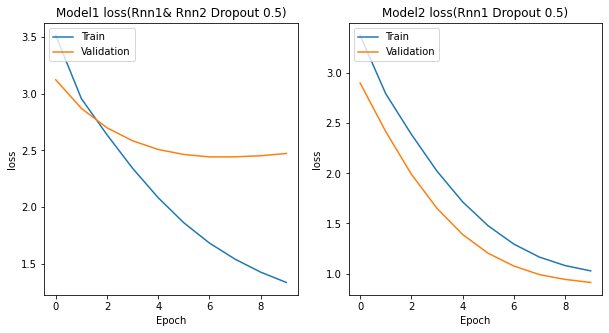

In [76]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
plt.plot(data1.history['loss'])
plt.plot(data1.history['val_loss'])
plt.title('Model1 loss(Rnn1& Rnn2 Dropout 0.5)')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

ax1 = fig.add_subplot(1,2,2)
plt.plot(data2.history['loss'])
plt.plot(data2.history['val_loss'])
plt.title('Model2 loss(Rnn1 Dropout 0.5)')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

---

## 6. 회고 
고난의 연속이었던 작사가 만들기 프로젝트.. 휴일 내내 모델만 돌린 것 같다.
덕분에 내가 많이 부족하다는 것을 다시 한번 느끼게 되었다.

사실 이전에는 loss 값도 중요하게 생각하긴 했지만 accuracy에 좀 더 집중 했던 것 같다.
이렇게 loss값에 집중한 적이 있었던가..? 하고 생각을 하다보니, 그 동안은 많은 것을 간과하고 있었던 것 같다고 느꼈다.

이번 기회를 통해 loss 값에 대해서도 많이 생각하게 되고 rnn에 대해서도 많이 배운 것 같다. 

그리고 loss 값의 변화를 시각화 하고 싶다는 생각이 들어 서치를 하다보니 keras 에서 모델 훈련 history를 확인할 수 있다는 사실도 알게되었다.

여러모로 나를 많이 채울 수 있는 프로젝트 였다고 생각한다.

이후에 더 확실하게 loss를 잡을 수 있는 방법을 찾아봐야겠다.


---

## 참고 자료

[Keras Documentation](https://keras.io/ko/visualization/)
